In [1]:
import os
import warnings
import random
import shutil  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = os.path.join('data','train')  
test_path = os.path.join('data','test')
train_datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.1,
                            rotation_range=30,
                            zoom_range=0.15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            horizontal_flip=True,
                            fill_mode="nearest")
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_gen = train_datagen.flow_from_directory(directory=train_path,
                                              target_size=(150,150),
                                              batch_size=32,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='training')

val_gen = train_datagen.flow_from_directory(directory=train_path,
                                            target_size=(150,150),
                                            batch_size=32, 
                                            shuffle=True,
                                            class_mode='binary',
                                            subset='validation')

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                            target_size=(150,150),
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode='binary')
classes = ['Parasitized','Uninfected']

Found 22322 images belonging to 2 classes.
Found 2480 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


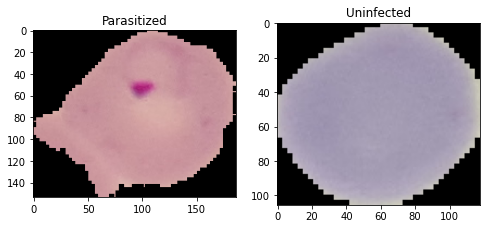

In [21]:
from PIL import Image
infected_dir = os.path.join('cell_images','Parasitized')
uninfected_dir = os.path.join('cell_images','Uninfected')

# select random infected pic
rand_norm = np.random.randint(0, len(os.listdir(infected_dir)))
infected_pic = os.listdir(infected_dir)[rand_norm]
infected_pic_address = os.path.join('cell_images','Parasitized',infected_pic)

# select random uninfected pic
rand_norm = np.random.randint(0, len(os.listdir(uninfected_dir)))
uninfected_pic = os.listdir(uninfected_dir)[rand_norm]
uninfected_pic_address = os.path.join('cell_images','Uninfected',uninfected_pic)

# load the images
infected_load = Image.open(infected_pic_address)
uninfected_load = Image.open(uninfected_pic_address)

# plot the images
f = plt.figure(figsize= (8,8))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(infected_load, cmap='gray')
a1.set_title('Parasitized');

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(uninfected_load, cmap='gray')
a2.set_title('Uninfected');